# Header

DKE가 뭔지 여기서 차근차근 알아보도록 하자. 
paper가 준 data를 받아서 어떻게 만들었는지 알아보자.

In [1]:
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

### The paper is reproducible!

이렇게 하니까 Fig 1과 동일한 그림을 그릴 수 있어여ㅛ!
```python
dataset = xr.open_dataset('dataset_paper/pangu1000.nc')
u = dataset['u'].var(dim="ens")
v = dataset['v'].var(dim="ens")
dke = u + v

weights = np.cos(np.deg2rad(dke.lat))
weights.name = "weights"
dke_weighted = dke.weighted(weights)
dke_weighted = dke_weighted.mean(dim=("lat", "lon"))

# plot in y-axis log scale
dke_weighted.plot()
```

In [7]:
dataset = xr.open_dataset('dataset_paper/pangu1000/pangu1000.nc')
u = dataset['u'].var(dim="ens")
v = dataset['v'].var(dim="ens")

dke = u + v # (73, 721, 1440)

# calculate the weighted mean
weights = np.cos(np.deg2rad(dke.lat))
weights.name = "weights"
dke_weighted = dke.weighted(weights)
dke_weighted = dke_weighted.mean(dim=("lat", "lon"))

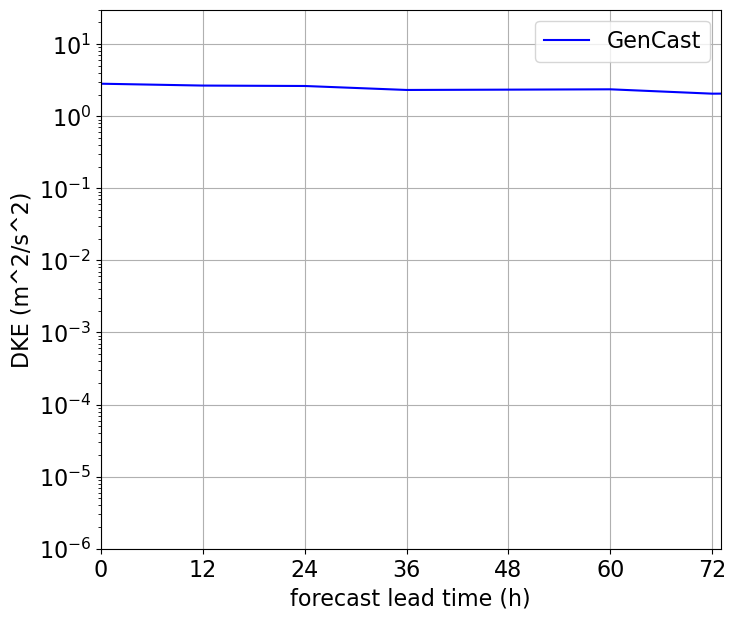

In [9]:
# plot dke in log-scale y axis

# increase the figure font size
plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(8, 7))
# plt.plot(np.arange(0, 73, 1), dke_weighted, color="red")

# dataset = xr.open_zarr("/geodata2/Gencast/output/2021-06-21.zarr").sel(level=300).squeeze()
# u = dataset['10m_u_component_of_wind'].var(dim="sample")
# v = dataset['10m_v_component_of_wind'].var(dim="sample")
dke = u + v # (73, 721, 1440)

# calculate the weighted mean
weights = np.cos(np.deg2rad(dke.lat))
weights.name = "weights"
dke_weighted = dke.weighted(weights)
dke_weighted = dke_weighted.mean(dim=("lat", "lon"))

plt.plot(np.arange(0, 12, 1)*12, dke_weighted.isel(time=slice(0, 12)), color="blue", label="GenCast")

plt.yscale("log")

# x axis: 0 ~ 72hr, hourly
plt.xticks(np.arange(0, 73, 12))
plt.xlim(0, 73)
plt.xlabel("forecast lead time (h)")
plt.ylim(10**-6, 30)
plt.ylabel("DKE (m^2/s^2)")
plt.grid()
plt.legend()
plt.show()
# plt.savefig("dke_weighted.png") 

```bash
 cdo remapbil,n360 pangu1000_ensavg.nc tmp.nc
 cdo uv2dv,linear tmp.nc pangu1000_dv.nc
 rm -f tmp.nc
 ```

In [ ]:

# dataset3 = xr.open_dataset("/geodata2/S2S/DL/GC_input/2021-06-21/ERA5_input.nc").squeeze()[["u_component_of_wind", "v_component_of_wind"]].drop_vars("batch")
# dataset3 = dataset3.rename({"u_component_of_wind":"u", "v_component_of_wind":"v"})
# dataset3.to_netcdf("/geodata2/Gencast/era5_2021-06-21.nc")
dataset3 = xr.open_dataset("/geodata2/Gencast/era5_divor_2021-06-21.nc")
dataset3
#  cdo remapbil,n360 pangu1000_ensavg.nc tmp.nc
#  cdo uv2dv,linear tmp.nc pangu1000_dv.nc

In [ ]:

u = dataset['u']
print(u.shape)
v = dataset['v']

dataset_ensavg = dataset.mean(dim="ens")
u_mean = dataset_ensavg['u']
print(u_mean.shape)
v_mean = dataset_ensavg['v']
u.time[24]

In [ ]:

u_hat = np.fft.rfft(u, axis=u.dims.index('lon'))
v_hat = np.fft.rfft(v, axis=v.dims.index('lon'))

u_mean_hat = np.fft.rfft(u_mean, axis=u_mean.dims.index('lon'))
v_mean_hat = np.fft.rfft(v_mean, axis=v_mean.dims.index('lon'))

# shape of x_hat = (5, 73, 721, 1440); (ens, time, lat, lon)
# shape of x_mean_hat = (73, 721, 1440); (time, lat, lon)
print(u_hat.shape)
print(u_mean_hat.shape)

$$e_i = \frac{1}{2}\left(\lvert\hat{u}\rvert^2 + \lvert\hat{v}\rvert^2\right)$$
$$e_{mean} = \frac{1}{N}\sum_i e_i(k, \phi)$$

In [ ]:
e_i = 0.5*(np.abs(u_hat)**2 + np.abs(v_hat)**2) # (5, 73, 721, 1440) = (ens, time, lat, lon)
e_mean = np.mean(e_i, axis=3) # (73, 721, 1440) = (time, lat, lon)
e_mean.shape

$$\overline{\tilde{e}}=\frac{1}{2}\left(\lvert\langle\tilde{u}_i(k, \phi)\rangle\rvert^2+\lvert\langle\tilde{v}_i(k, \phi)\rangle\rvert^2\right)$$

In [ ]:
e_mean_field = 0.5*(np.abs(u_mean_hat)**2 + np.abs(v_mean_hat)**2) # (73, 721, 1440)
e_mean_field.shape

$$\Delta \tilde{e}(k, \phi) = \frac{N}{N-1}(\langle e_i(k, \phi)\rangle - \overline{e}(k, \phi))$$

In [ ]:
N = u.shape[3] # 5
print(N)
DKE = (N/(N-1))*(e_mean - e_mean_field) # (73, 721, 1440)
DKE.shape

In [ ]:
k_dim = DKE.shape[2]
wavenumbers = np.arange(1, k_dim+1)
DKE_spectra = DKE * np.expand_dims(wavenumbers, axis=(0,1)) 

phi = np.deg2rad(dataset['lat'])
weights = np.cos(phi)
weights = weights / weights.sum()

weights_3d = np.expand_dims(weights, axis=(0,-1))

DKE_global = (DKE * weights_3d).mean(axis=1)

# DKE_k = DKE.mean(axis=1)
# nlon = u.sizes['lon']
# wavenumbers = np.arange(nlon)
# DKE_k = wavenumbers * DKE_k

# By Myself

In [ ]:
# dataset = xr.open_zarr("/geodata2/Gencast/output/2021-06-21.zarr").sel(level=300).squeeze()
dataset = xr.open_dataset('/home/hiskim1/graphcast/spectra/dataset_paper/pangu1000/pangu1000.nc').squeeze()

ens = "ens"

dataset

In [ ]:
u = dataset['u']
v = dataset['v']
u = dataset['10m_u_component_of_wind']
v = dataset['10m_v_component_of_wind']

print(u.shape) # (5, 73, 721, 1440) = (ens, time, lat, lon)

n = np.sqrt(u.shape[u.dims.index("lon")])

tilde_u = np.fft.fft(u,axis=u.dims.index("lon"))/n
tilde_v = np.fft.fft(v,axis=u.dims.index("lon"))/n

tilde_u.shape # (5, 73, 721, 721) = (ens, time, lat, wave)

### KE Spectra
$$
\tilde{e}(k)= \frac{k}{2}(\langle \lvert \tilde u_i\rvert^2\rangle + \langle \lvert \tilde v_i\rvert^2\rangle)
$$

In [ ]:
KE_spectra = 0.5 * (tilde_u * np.conj(tilde_u)).mean(axis=u.dims.index(ens)) + 0.5 * (tilde_v * np.conj(tilde_v)).mean(axis=u.dims.index(ens))

KE_spectra.shape

### DKE Spectra

$$\begin{align}
\Delta\tilde e  &= k(\text{var}(\tilde u) + \text{var}(\tilde v) )\\
&= k\frac{N}{N-1}(\underbrace{\langle \lvert \tilde u_i\rvert^2\rangle + \langle \lvert \tilde v_i\rvert^2\rangle}_{\text{ensemble mean of the KE spectral densities}} - \underbrace{(\langle \lvert \tilde u_i\rvert\rangle^2 + \langle \lvert \tilde v_i\rvert\rangle^2)}_{\text{KE spectral density of the ensemble mean}})
\end{align}$$

In [ ]:
var_tilde_u = tilde_u.var(axis=u.dims.index(ens), ddof=1)
var_tilde_v = tilde_v.var(axis=v.dims.index(ens), ddof=1)

DKE_spectra_1 = var_tilde_u + var_tilde_v

var_tilde_u.shape

In [ ]:
u_2_mean = ((tilde_u * np.conj(tilde_u))).mean(axis=u.dims.index(ens))
v_2_mean = ((tilde_v * np.conj(tilde_v))).mean(axis=v.dims.index(ens))

u_mean_2 = tilde_u.mean(axis=u.dims.index(ens)) * np.conj(tilde_u.mean(axis=u.dims.index(ens)))
v_mean_2 = tilde_v.mean(axis=v.dims.index(ens)) * np.conj(tilde_v.mean(axis=u.dims.index(ens)))

N = u.shape[u.dims.index(ens)]
bias = N/(N-1)

DKE_spectra_2 = bias * (u_2_mean + v_2_mean - u_mean_2 - v_mean_2)
DKE_spectra_2.shape

In [ ]:
# weight by cos(lat)

spectra = DKE_spectra_2
print(spectra.shape)
phi = np.deg2rad(dataset['lat'])
weight = np.cos(phi)

k = ((np.arange(spectra.shape[2])+1) * 2 * np.pi * 6317)/spectra.shape[2]
map = np.outer(weight, k)

# print(map.shape)
# spectra = spectra * map
# k = np.arange(spectra.shape[2]) + 1
# print(k)
# spectra = spectra * np.flip(k)

weights = weight / weight.sum()

weights_3d = np.expand_dims(weights, axis=(0 ,-1))
print(weights_3d.shape)

spectra = spectra * weights_3d
print(spectra.shape)

DKE_global = spectra.mean(axis=1)

DKE_global.shape

### Plot

In [ ]:

import matplotlib.pyplot as plt
colors = plt.cm.cividis(np.linspace(0, 1, 60))

data = DKE_global[0]*0.5

# Initialize figure with research-quality specifications
plt.figure(figsize=(16, 9))

# Calculate wavelength array (assuming spherical harmonics)
n360_circumference = 40075  # Earth's circumference in km
wavenumbers = np.arange(1, len(DKE_global[0])+1)
wavelengths = n360_circumference / wavenumbers  # Convert to wavelengths in km

# Create loglog plot with reversed x-axis
# plt.loglog(10**log_k, DKE_log_defined, 'k-', linewidth=1.5, label='Total KE')

for i in range(0, 60, 4):
    data = DKE_global[i]*0.5
    plt.loglog(wavelengths, 
               data, 
               color=colors[i], 
               # label=f'{(i+1)*12}h',
               label=f"{i}h"
               )

# Configure axes
# plt.grid(True, which="both", ls="-", alpha=0.2)

# Set labels with units
plt.xlabel('wavelength [km]')
plt.ylabel('spectral density [m²s⁻²]')
# plt.title('Pangu-100%')

# Set axis limits to match reference plot
# plt.xlim(70, 2.5*10**4)
plt.gca().invert_xaxis()  # Reverse x-axis direction
# plt.ylim(10**-3, 2*10**2)
plt.legend()
plt.tight_layout()
# plt.savefig("dke_iconlr1000.png")

---
# From Vorticity and Divergence

In [ ]:
import xarray as xr



RuntimeError: NetCDF: HDF error